<a href="https://colab.research.google.com/github/trishaa4144/cmsc320-final/blob/rat_clean/CMSC320_Checkpt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Data Cleaning


First, we import our dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("Rat_Sightings_20240917.csv")
print(df.columns)

<ipython-input-64-910fe799d608>:5: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Rat_Sightings_20240917.csv")


Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Action Updated Date', 'Community Board', 'Borough',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')


We filter out unnecessary/sparse columns like "Taxi Pick Up Location", "Bridge Highway Name", etc. We are deciding to look at the following important categories.

In [ ]:
# Keep only the necessary columns
df = df[['Created Date', 'Location Type', 'Incident Zip', 'Community Board', 'Borough', 'Latitude', 'Longitude']]
# print(df.columns)
# print(df.head())
# print(df.size) ----------------------------------------- 1772883

Next, we filter out household types.



In [ ]:
# Get unique values in 'Location Type'
unique_location_types = df['Location Type'].unique()
# print(unique_location_types)

# Filter out rows with 'Location Type' that are not related to households/family
# household_types = ['1-2 Family Dwelling', '3+ Family Apt. Building', 'Mixed Use Building']
# df = df[df['Location Type'].isin(household_types)]
# print(df.head())
# print(df.size) # 1073513

Next, we remove Boroughs that are "Unspecified" from the dataframe.

In [ ]:
# Drop rows with unspecified boroughs
df = df[df['Borough'] != 'Unspecified']

# Optionally, reset the index after filtering
df.reset_index(drop=True, inplace=True)

# Check the result
print(df.head())

      Created Date            Location Type  Incident Zip Community Board  \
0   5/31/2024 0:10               Vacant Lot       11377.0       02 QUEENS   
1   6/1/2024 15:01      1-2 Family Dwelling       11357.0       07 QUEENS   
2   6/6/2024 10:08  3+ Family Apt. Building       11385.0       05 QUEENS   
3  6/25/2024 11:34  3+ Family Apt. Building       10467.0        07 BRONX   
4  6/27/2024 10:48      1-2 Family Dwelling       11220.0     07 BROOKLYN   

    Borough   Latitude  Longitude  
0    QUEENS  40.740375 -73.896454  
1    QUEENS  40.781667 -73.807381  
2    QUEENS  40.705669 -73.908352  
3     BRONX  40.884066 -73.879225  
4  BROOKLYN  40.642061 -74.015862  


Questions to Answer:
What are the main characteristics of your dataset?
Borough
Location Type (households, residential, nonresidential areas)
Date
Zip Codes
Income ranges
How many features and entries are there?

Let's visualize how rat sightings compare across Zip Codes

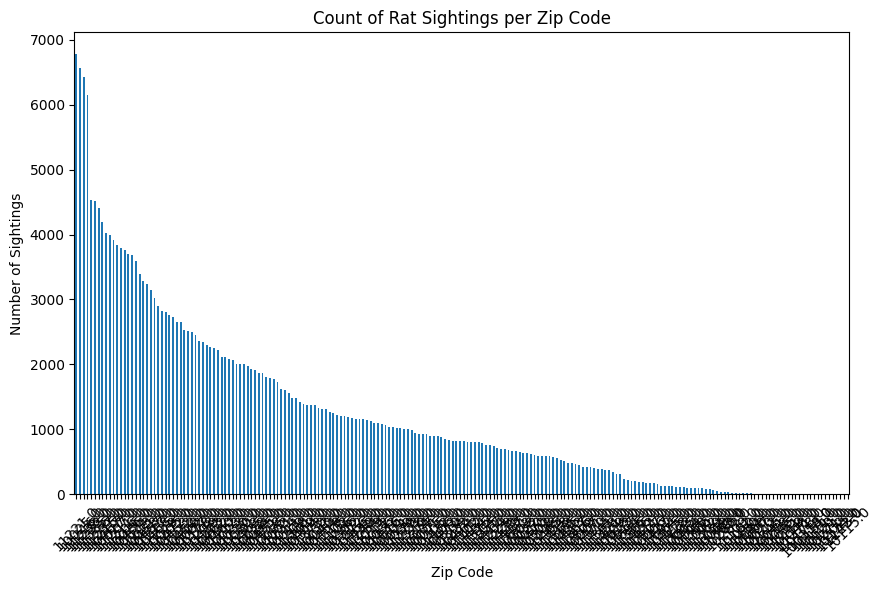

In [ ]:
# Count rat sightings per zip code
rat_sightings_by_zip = df['Incident Zip'].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))
rat_sightings_by_zip.plot(kind='bar')
plt.title('Count of Rat Sightings per Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

Extract the month, week, and day from the dates in the dataset.

In [ ]:
# Convert 'Created Date' to datetime format
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Extract month, week, and day information
df['Month'] = df['Created Date'].dt.month
df['Week'] = df['Created Date'].dt.isocalendar().week
df['Day'] = df['Created Date'].dt.day

# Check the updated dataframe
print(df[['Created Date', 'Month', 'Week', 'Day']].head())

         Created Date  Month  Week  Day
0 2024-05-31 00:10:00      5    22   31
1 2024-06-01 15:01:00      6    22    1
2 2024-06-06 10:08:00      6    23    6
3 2024-06-25 11:34:00      6    26   25
4 2024-06-27 10:48:00      6    26   27


Visualize Rat sightings across Months

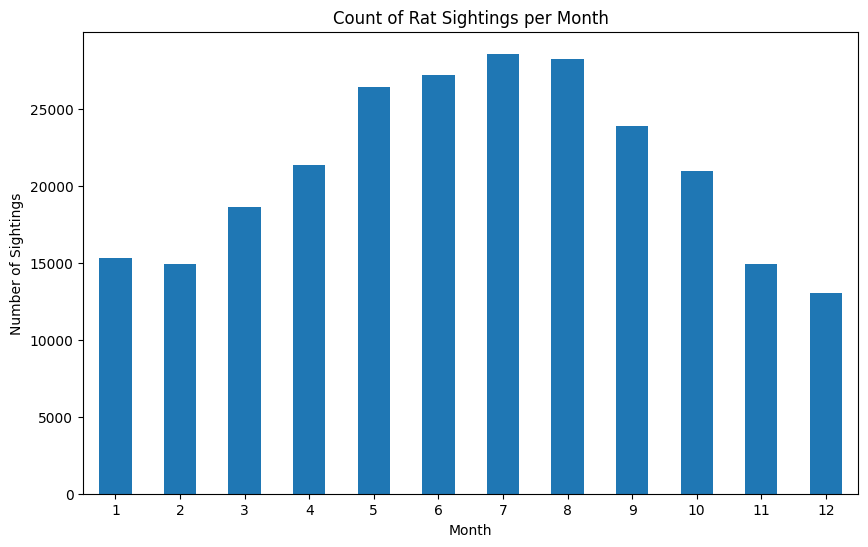

In [ ]:
# Count rat sightings per month
rat_sightings_by_month = df['Month'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
rat_sightings_by_month.plot(kind='bar')
plt.title('Count of Rat Sightings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=0)
plt.show()

## T-test: Summer vs Winter Rat Sightings

In [ ]:
# Example: Compare rat sightings between Winter (Dec-Feb) and Summer (Jun-Aug)
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

# Get sightings for winter and summer
winter_sightings = df[df['Month'].isin(winter_months)]['Month'].count()
summer_sightings = df[df['Month'].isin(summer_months)]['Month'].count()

# Filter the data for winter and summer months
winter_data = df[df['Month'].isin([12, 1, 2])]
summer_data = df[df['Month'].isin([6, 7, 8])]


In [ ]:
# Check the length of data for both groups
print("Winter sightings count:", len(winter_data))
print("Summer sightings count:", len(summer_data))

Winter sightings count: 43219
Summer sightings count: 83944


In [ ]:
# Check for NaN values in these groups
print("NaN in winter data:", winter_data.isna().sum())
print("NaN in summer data:", summer_data.isna().sum())

# Drop rows with missing values in 'Incident Zip', 'Latitude', or 'Longitude'
winter_data_clean = winter_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])
summer_data_clean = summer_data.dropna(subset=['Incident Zip', 'Latitude', 'Longitude'])

# Check cleaned data
print("Cleaned winter data count:", len(winter_data_clean))
print("Cleaned summer data count:", len(summer_data_clean))

NaN in winter data: Created Date         0
Location Type        4
Incident Zip        54
Community Board      0
Borough              0
Latitude           279
Longitude          279
Month                0
Week                 0
Day                  0
dtype: int64
NaN in summer data: Created Date         0
Location Type        4
Incident Zip       147
Community Board      1
Borough              1
Latitude           967
Longitude          967
Month                0
Week                 0
Day                  0
dtype: int64
Cleaned winter data count: 42937
Cleaned summer data count: 82972


T test: T-test is only valid if the sample size is normally distributed and independent. By the Central Limit theorem, since the sizes of both datasets are over 30, a normal distribution can be assumed.

In [ ]:
# Count the number of sightings per day in both seasons
winter_sightings_per_day = winter_data_clean['Created Date'].dt.date.value_counts()
summer_sightings_per_day = summer_data_clean['Created Date'].dt.date.value_counts()

# Perform the t-test comparing the number of sightings per day in winter vs summer
t_stat, p_value = stats.ttest_ind(winter_sightings_per_day, summer_sightings_per_day, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -32.51880858690508, P-value: 2.2571798235661205e-193


# ANOVA Test :  Zip Codes


H0: There are no significant differences in rat sightings across boroughs

H1: There are significant differences in rat sightings across boroughs


We Reject the null hypothesis (H0) because the p-value is less than the alpha value of 0.05.

In [ ]:
from scipy import stats

sightings_per_zip = df.groupby(['Borough', 'Incident Zip']).size().reset_index(name='Sightings')

# group by Borough to prepare for ANOVA
sightings_by_borough = sightings_per_zip.groupby('Borough')['Sightings'].apply(list).reset_index()
print(sightings_by_borough)

# Extracting sightings lists for each borough
borough_groups = sightings_by_borough['Sightings'].tolist()

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*borough_groups)

print(f'P-value: {p_value}')

         Borough                                          Sightings
0          BRONX  [1, 1802, 2529, 2659, 1310, 1861, 3680, 3144, ...
1       BROOKLYN  [1, 1, 2003, 1, 2276, 743, 2767, 3768, 3835, 2...
2      MANHATTAN  [26, 8, 926, 2502, 1726, 103, 108, 169, 418, 2...
3         QUEENS  [91, 67, 18, 1414, 807, 1218, 791, 1247, 882, ...
4  STATEN ISLAND  [1038, 593, 645, 827, 902, 1210, 181, 591, 422...
F-statistic: 10.551718360097862, P-value: 7.823436243703136e-08
Reject the null hypothesis (H0): There are significant differences in mean rat sightings across boroughs.


Next, let's visualize the results of the ANOVA Test.

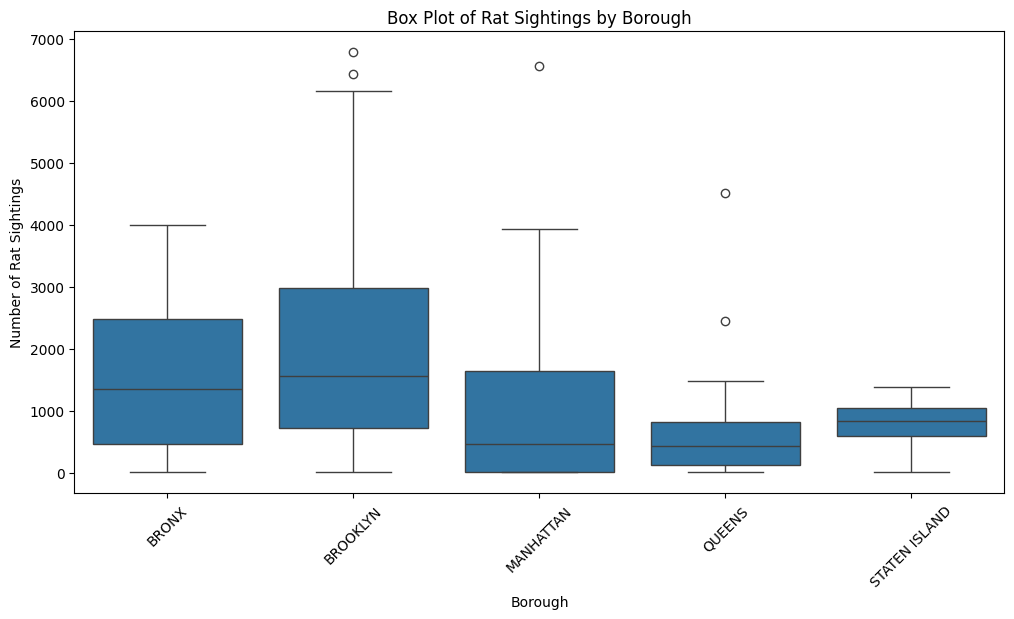

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='Borough', y='Sightings', data=sightings_per_zip)
plt.title('Box Plot of Rat Sightings by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Rat Sightings')
plt.xticks(rotation=45)
plt.show()


### Post-hoc Test: Turkey's HSD Test



In [ ]:
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

long_df = sightings_per_zip[['Borough', 'Sightings']].copy()
long_df = long_df.explode('Sightings').reset_index(drop=True)
long_df['Sightings'] = pd.to_numeric(long_df['Sightings'], errors='coerce')

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(long_df['Sightings'], long_df['Borough'], alpha=0.05)
print(tukey_results)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1      group2     meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------
    BRONX      BROOKLYN   509.2754 0.3984  -285.6432 1304.1939  False
    BRONX     MANHATTAN  -543.0392 0.2637 -1285.4655  199.3871  False
    BRONX        QUEENS  -925.4091 0.0068  -1671.271 -179.5472   True
    BRONX STATEN ISLAND  -757.4872 0.3463 -1882.2406  367.2662  False
 BROOKLYN     MANHATTAN -1052.3146 0.0001 -1698.9722 -405.6569   True
 BROOKLYN        QUEENS -1434.6845    0.0 -2085.2836 -784.0853   True
 BROOKLYN STATEN ISLAND -1266.7625 0.0107  -2330.736 -202.7891   True
MANHATTAN        QUEENS  -382.3699 0.3779  -967.6737  202.9339  False
MANHATTAN STATEN ISLAND   -214.448 0.9786 -1239.7971  810.9011  False
   QUEENS STATEN ISLAND   167.9219 0.9915  -859.9175 1195.7614  False
---------------------------------------------------------------------


The results suggest that Brooklyn has significantly lower rat sightings compared to boroughs such as Manhattan, Queens, and Staten Island.

The results do not suggest significant differences in sightings between Bronx and Brooklyn, or between some other borough pairs.